In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras.models import Sequential
from google.colab import files
from tensorflow.keras import layers, models

# Setting Up the Path for the images

In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [3]:
!pwd

/content


#### Giving path to the google drive

In [4]:
data_dir_train = pathlib.Path("drive/My Drive/Important Docs/ISIC/Train/")
data_dir_test = pathlib.Path('drive/My Drive/Important Docs/ISIC/Test/')

#### Printing out the number of images in the train and test folders

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2303
118


#### Parameters for the images

In [6]:
batch_size = 32
img_height = 180
img_width = 180

#### Splitting up the Data in Validation and Training set

In [7]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32
)

Found 2303 files belonging to 9 classes.
Using 1843 files for training.


In [8]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2303 files belonging to 9 classes.
Using 460 files for validation.


#### Printing out the Class Labels

In [9]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualisation

#### Visualising atleast 1 image from each class

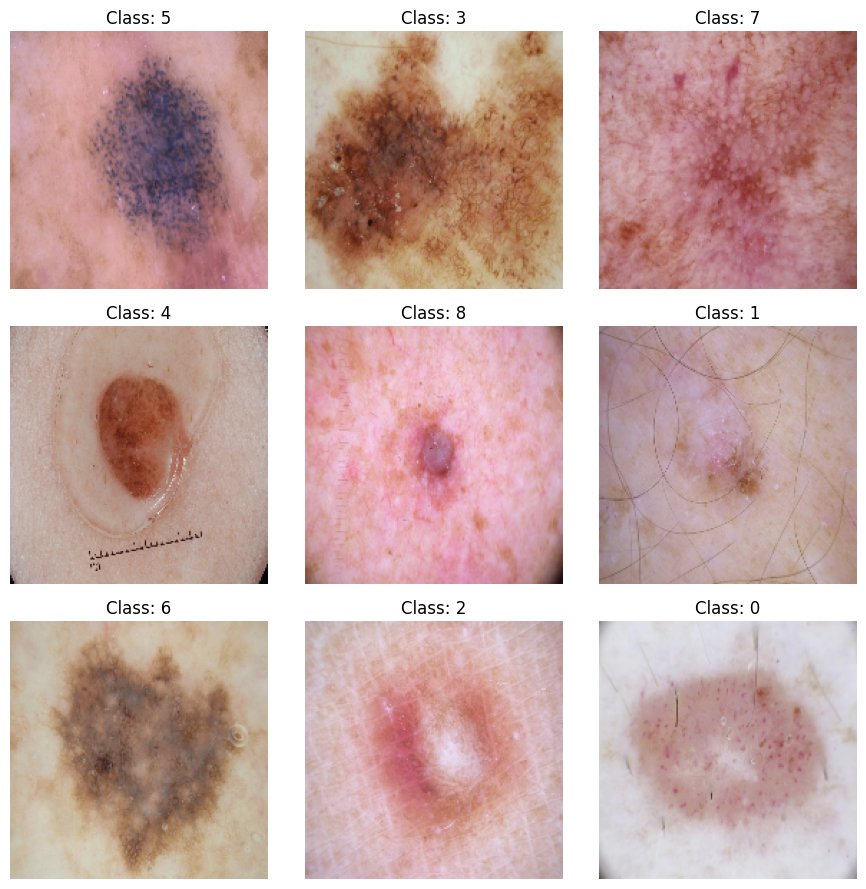

In [10]:
import matplotlib.pyplot as plt

visualized_classes = set()

# Initialize a dictionary to store one instance of each class
class_images = {}

# Iterate through the dataset
for images, labels in train_ds:
    for img, lbl in zip(images, labels):
        # If the label is new, store the image and add the label to our set
        if lbl.numpy() not in visualized_classes:
            class_images[lbl.numpy()] = img
            visualized_classes.add(lbl.numpy())

        # Stop once we have visualized all nine classes
        if len(visualized_classes) == 9:
            break

    if len(visualized_classes) == 9:
        break

# Plot the images
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for ax, (lbl, img) in zip(axes.ravel(), class_images.items()):
    ax.imshow(img.numpy().astype("uint8"))
    ax.set_title(f"Class: {lbl}")
    ax.axis("off")

plt.tight_layout()
plt.show()

##### Tensor Flow Best Practice
##### -  automatically determine the optimal number of batches to prefetch, which can help improve runtime performance
##### - Caching means that the dataset will be stored in memory or a local storage after the first epoch, which ensures that reading data from disk (which can be slow) is avoided in subsequent epochs.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)


#### Performing Normalisation of the images by dividing it by 255

In [12]:
rescale = layers.experimental.preprocessing.Rescaling(1./255)


# Model Building

#### Creating a common method for building a model.Since it is a multi-classification problem we are making use of Softmax function.

In [13]:
def make_model(input_shape, num_classes):
    model = models.Sequential([
        rescale,
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


#### Compiling the Model

In [14]:
input_shape = (img_height, img_width, 3)  # 3 for RGB channels
num_classes = 9

model = make_model(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Fitting the model on the datasets with 20 epochs

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
58/58 [==============================] - 176s 688ms/step - loss: 2.0622 - accuracy: 0.2257 - val_loss: 1.9563 - val_accuracy: 0.3239
Epoch 2/20
58/58 [==============================] - 2s 32ms/step - loss: 1.7758 - accuracy: 0.3603 - val_loss: 1.5596 - val_accuracy: 0.4761
Epoch 3/20
58/58 [==============================] - 2s 33ms/step - loss: 1.6196 - accuracy: 0.4373 - val_loss: 1.5053 - val_accuracy: 0.4935
Epoch 4/20
58/58 [==============================] - 2s 33ms/step - loss: 1.5322 - accuracy: 0.4476 - val_loss: 1.4182 - val_accuracy: 0.4957
Epoch 5/20
58/58 [==============================] - 2s 32ms/step - loss: 1.4582 - accuracy: 0.5046 - val_loss: 1.4440 - val_accuracy: 0.5283
Epoch 6/20
58/58 [==============================] - 2s 32ms/step - loss: 1.4526 - accuracy: 0.4889 - val_loss: 1.5220 - val_accuracy: 0.4739
Epoch 7/20
58/58 [==============================] - 2s 33ms/step - loss: 1.3605 - accuracy: 0.5247 - val_loss: 1.4211 - val_accuracy: 0.4826
Epoch 8/20

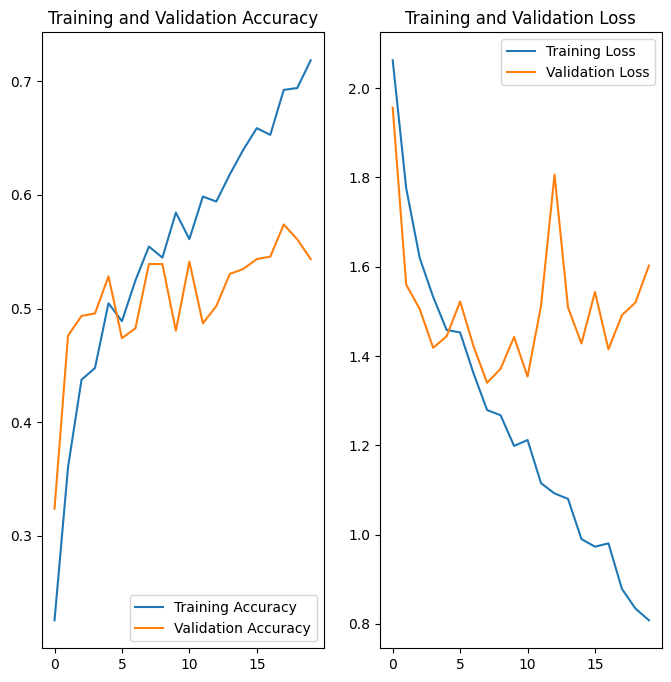

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### With out first model we can see that the results are not Good. The model is underfitting.There could be several reasons for it.Class Imbalance could be on of them

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [18]:
training_accuracy = history.history['accuracy'][-1]

print(f"Training Accuracy of the Model: {training_accuracy * 100:.2f}%")

Training Accuracy of the Model: 71.84%


In [19]:
loss, accuracy =model.evaluate(validation_dataset)

15/15 [==============================] - 0s 11ms/step - loss: 1.6024 - accuracy: 0.5435


In [20]:
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Loss: 1.6024
Validation Accuracy: 54.35%


In [21]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Model 2

#### Performing Data Augmentation to improve the number of images that we have.We will be flipping the image and rotating it

In [22]:
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

#### Building the model again with data augmentation

In [23]:
def make_model(input_shape, num_classes):
    model = models.Sequential([
        data_augmentation,
        rescale,
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


#### Compiling the Model

In [24]:
input_shape = (img_height, img_width, 3)  # 3 for RGB channels
num_classes = 9

model_aug = make_model(input_shape=input_shape, num_classes=num_classes)
model_aug.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Fitting the augmented model with the dataset

In [25]:
epochs = 20
history = model_aug.fit(
  train_ds,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
58/58 [==============================] - 5s 44ms/step - loss: 1.9939 - accuracy: 0.2724 - val_loss: 1.7933 - val_accuracy: 0.4065
Epoch 2/20
58/58 [==============================] - 2s 36ms/step - loss: 1.7753 - accuracy: 0.3804 - val_loss: 1.6320 - val_accuracy: 0.4304
Epoch 3/20
58/58 [==============================] - 2s 37ms/step - loss: 1.6851 - accuracy: 0.3950 - val_loss: 1.5090 - val_accuracy: 0.4696
Epoch 4/20
58/58 [==============================] - 2s 34ms/step - loss: 1.5665 - accuracy: 0.4672 - val_loss: 1.4420 - val_accuracy: 0.5152
Epoch 5/20
58/58 [==============================] - 2s 35ms/step - loss: 1.5211 - accuracy: 0.4835 - val_loss: 1.4361 - val_accuracy: 0.4891
Epoch 6/20
58/58 [==============================] - 2s 36ms/step - loss: 1.4749 - accuracy: 0.4986 - val_loss: 1.4346 - val_accuracy: 0.5152
Epoch 7/20
58/58 [==============================] - 2s 36ms/step - loss: 1.4351 - accuracy: 0.5198 - val_loss: 1.4187 - val_accuracy: 0.5326
Epoch 8/20
58

In [26]:
loss, accuracy =model_aug.evaluate(validation_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

15/15 [==============================] - 0s 11ms/step - loss: 1.3183 - accuracy: 0.5326
Validation Loss: 1.3183
Validation Accuracy: 53.26%


#### We can see that the accuracy of the model is not good with augmentation as well.

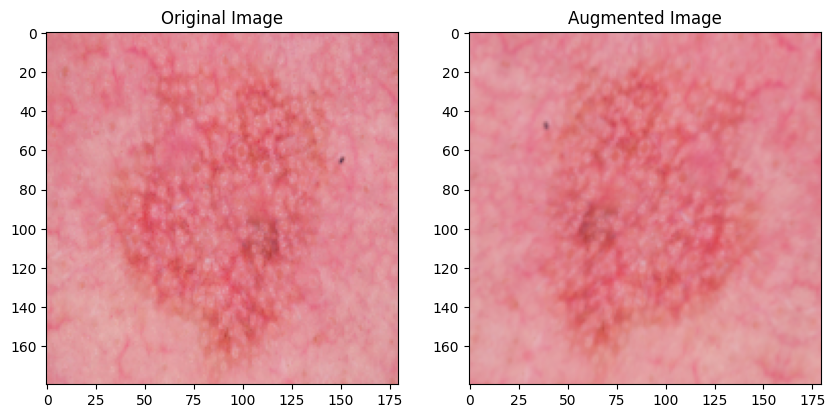

In [27]:
images, labels = next(iter(train_ds))

# Take the first image from this batch
sample_image = images[0]
augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(sample_image.numpy().astype("uint8"))
plt.title("Original Image")

# Augmented Image
plt.subplot(1, 2, 2)
plt.imshow(augmented_image[0].numpy().astype("uint8"))
plt.title("Augmented Image")

plt.show()

## Model 3

#### Now we will make use of dropout layer along with Augmentation to check the model accuracy

In [28]:
model_dr = Sequential([
    data_augmentation,  # Assuming you're using data augmentation
    rescale,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer with 50% dropout rate
    layers.Dense(9, activation='softmax')  # Assuming 9 classes
])






#### Fitting the model on the data

In [29]:
epochs_val = 20
model_dr.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_dr.fit(train_ds, validation_data=validation_dataset, epochs=epochs_val)


Epoch 1/20
58/58 [==============================] - 4s 38ms/step - loss: 1.9630 - accuracy: 0.3142 - val_loss: 1.7069 - val_accuracy: 0.3957
Epoch 2/20
58/58 [==============================] - 2s 35ms/step - loss: 1.7746 - accuracy: 0.3722 - val_loss: 1.6294 - val_accuracy: 0.3761
Epoch 3/20
58/58 [==============================] - 2s 38ms/step - loss: 1.7105 - accuracy: 0.3782 - val_loss: 1.5360 - val_accuracy: 0.4283
Epoch 4/20
58/58 [==============================] - 2s 35ms/step - loss: 1.5794 - accuracy: 0.4482 - val_loss: 1.5152 - val_accuracy: 0.4478
Epoch 5/20
58/58 [==============================] - 2s 34ms/step - loss: 1.5201 - accuracy: 0.4791 - val_loss: 1.4598 - val_accuracy: 0.4783
Epoch 6/20
58/58 [==============================] - 2s 34ms/step - loss: 1.4628 - accuracy: 0.4997 - val_loss: 1.3742 - val_accuracy: 0.4891
Epoch 7/20
58/58 [==============================] - 2s 34ms/step - loss: 1.4093 - accuracy: 0.5128 - val_loss: 1.3682 - val_accuracy: 0.5152
Epoch 8/20
58

#### Evaluating the model

In [30]:
loss, accuracy =model_dr.evaluate(validation_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

15/15 [==============================] - 0s 11ms/step - loss: 1.2432 - accuracy: 0.5457
Validation Loss: 1.2432
Validation Accuracy: 54.57%


#### Accuracy of the model is not good

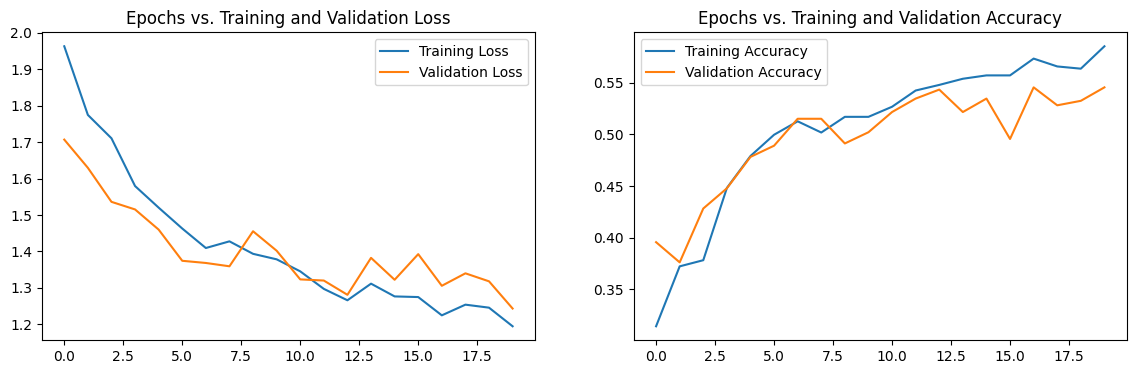

In [31]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')

plt.show()


# Investigating Class Imablance

Class 5: 390 instances
Class 2: 77 instances
Class 1: 333 instances
Class 8: 115 instances
Class 3: 355 instances
Class 7: 141 instances
Class 4: 282 instances
Class 0: 89 instances
Class 6: 61 instances


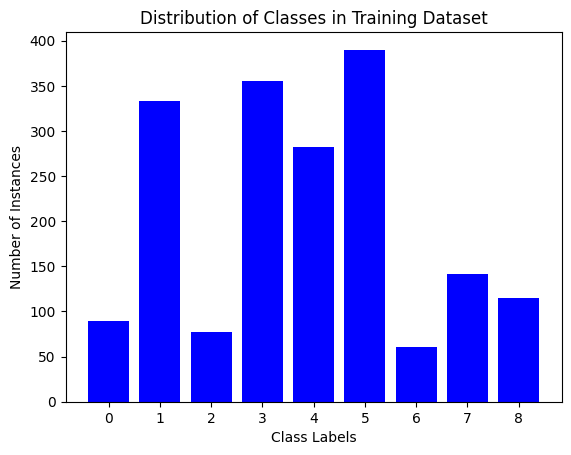

In [32]:
class_counts = {}
for images, labels in train_ds:
    for label in labels:
        lbl = label.numpy()
        class_counts[lbl] = class_counts.get(lbl, 0) + 1
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} instances")
import matplotlib.pyplot as plt

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.bar(classes, counts, color='blue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Instances')
plt.title('Distribution of Classes in Training Dataset')
plt.xticks(classes)  # This ensures each class label gets a tick on the x-axis
plt.show()

#### Answering some of the questions

Which class has the least number of samples?
6

Which classes dominate the data in terms proportionate number of samples? Class 5

In [33]:
!pip install Augmentor

## Performing Augmentation of the images

In [34]:
path_to_training_dataset="drive/My Drive/Important Docs/ISIC/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to drive/My Drive/Important Docs/ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2A0412E6B0>: 100%|██████████| 500/500 [00:17<00:00, 28.35 Samples/s]


Initialised with 410 image(s) found.
Output directory set to drive/My Drive/Important Docs/ISIC/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2A1456BE80>: 100%|██████████| 500/500 [00:17<00:00, 28.42 Samples/s]


Initialised with 95 image(s) found.
Output directory set to drive/My Drive/Important Docs/ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2A14179510>: 100%|██████████| 500/500 [00:18<00:00, 27.41 Samples/s]


Initialised with 438 image(s) found.
Output directory set to drive/My Drive/Important Docs/ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2A140A1510>: 100%|██████████| 500/500 [01:24<00:00,  5.90 Samples/s]


Initialised with 357 image(s) found.
Output directory set to drive/My Drive/Important Docs/ISIC/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2A041DBA00>: 100%|██████████| 500/500 [01:24<00:00,  5.93 Samples/s]


Initialised with 492 image(s) found.
Output directory set to drive/My Drive/Important Docs/ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2A00533E50>: 100%|██████████| 500/500 [00:18<00:00, 27.42 Samples/s]


Initialised with 77 image(s) found.
Output directory set to drive/My Drive/Important Docs/ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2A04118340>: 100%|██████████| 500/500 [00:40<00:00, 12.46 Samples/s]


Initialised with 181 image(s) found.
Output directory set to drive/My Drive/Important Docs/ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2A145963E0>: 100%|██████████| 500/500 [00:18<00:00, 26.86 Samples/s]


Initialised with 139 image(s) found.
Output directory set to drive/My Drive/Important Docs/ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2A09F57E20>: 100%|██████████| 500/500 [00:21<00:00, 23.81 Samples/s]


#### Adding the newly created images in the path

In [35]:
from glob import glob
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### Performing the split with the new set of data

In [37]:
data_dir_train="drive/My Drive/Important Docs/ISIC/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6803 files belonging to 9 classes.
Using 5443 files for training.


In [38]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6803 files belonging to 9 classes.
Using 1360 files for validation.


# Model 4

In [39]:
input_shape = (img_height, img_width, 3)  # 3 for RGB channels
num_classes = 9

model_augmented = make_model(input_shape=input_shape, num_classes=num_classes)
model_augmented.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
epochs = 50
history = model_augmented.fit(
  train_ds,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/50
171/171 [==============================] - 40s 213ms/step - loss: 1.9860 - accuracy: 0.2523 - val_loss: 1.9480 - val_accuracy: 0.3059
Epoch 2/50
171/171 [==============================] - 36s 206ms/step - loss: 1.6586 - accuracy: 0.3629 - val_loss: 1.4264 - val_accuracy: 0.4860
Epoch 3/50
171/171 [==============================] - 37s 208ms/step - loss: 1.5255 - accuracy: 0.4174 - val_loss: 1.3923 - val_accuracy: 0.4868
Epoch 4/50
171/171 [==============================] - 36s 207ms/step - loss: 1.4715 - accuracy: 0.4371 - val_loss: 1.3359 - val_accuracy: 0.4816
Epoch 5/50
171/171 [==============================] - 35s 200ms/step - loss: 1.3915 - accuracy: 0.4630 - val_loss: 1.3592 - val_accuracy: 0.4566
Epoch 6/50
171/171 [==============================] - 36s 208ms/step - loss: 1.3443 - accuracy: 0.4683 - val_loss: 1.1843 - val_accuracy: 0.5412
Epoch 7/50
171/171 [==============================] - 35s 199ms/step - loss: 1.3709 - accuracy: 0.4727 - val_loss: 1.2116 - val_ac

In [41]:
loss,accuracy=model_augmented.evaluate(validation_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

43/43 [==============================] - 7s 146ms/step - loss: 0.6200 - accuracy: 0.7735
Validation Loss: 0.6200
Validation Accuracy: 77.35%


#### We get validation accuracy of 77% which is better than the initial value we got

# Model 5

In [42]:
epochs_val = 50
model_dr.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_dr.fit(train_ds, validation_data=validation_dataset, epochs=epochs_val)

Epoch 1/50
171/171 [==============================] - 37s 195ms/step - loss: 1.3642 - accuracy: 0.4740 - val_loss: 1.1597 - val_accuracy: 0.5507
Epoch 2/50
171/171 [==============================] - 35s 198ms/step - loss: 1.3122 - accuracy: 0.4905 - val_loss: 1.2206 - val_accuracy: 0.5346
Epoch 3/50
171/171 [==============================] - 39s 224ms/step - loss: 1.3346 - accuracy: 0.4869 - val_loss: 1.1401 - val_accuracy: 0.5434
Epoch 4/50
171/171 [==============================] - 36s 203ms/step - loss: 1.2552 - accuracy: 0.5087 - val_loss: 1.0713 - val_accuracy: 0.5897
Epoch 5/50
171/171 [==============================] - 34s 195ms/step - loss: 1.2904 - accuracy: 0.5019 - val_loss: 1.0278 - val_accuracy: 0.5934
Epoch 6/50
171/171 [==============================] - 36s 203ms/step - loss: 1.2277 - accuracy: 0.5299 - val_loss: 1.0676 - val_accuracy: 0.5853
Epoch 7/50
171/171 [==============================] - 35s 197ms/step - loss: 1.1708 - accuracy: 0.5468 - val_loss: 1.0255 - val_ac

In [43]:
loss,accuracy=model_dr.evaluate(validation_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

43/43 [==============================] - 8s 153ms/step - loss: 0.4991 - accuracy: 0.8265
Validation Loss: 0.4991
Validation Accuracy: 82.65%


#### This model with drop out layer with 50 epochs is the best model we have got till now with 83% accuracy